In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import save_image
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import random

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HR_SIZE = 128
LR_SIZE = 32
BATCH_SIZE = 16
EPOCHS_PRETRAIN = 10
EPOCHS_GAN = 40

# ... (Partie téléchargement inchangée) ...
# 1. Nettoyage et Téléchargement DIV2K
os.system("rm -rf data results DIV2K_train_HR.zip")
os.makedirs("results", exist_ok=True)
print("📥 Téléchargement de DIV2K...")
os.system("wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip")
os.system("unzip -q DIV2K_train_HR.zip -d data")
os.system("mv data/DIV2K_train_HR data/hr")

# 2. Classe Dataset CORRIGÉE (Resize PIL avant Tensor)
class SRDataset(Dataset):
    def __init__(self, root_dir="data/hr", crop_size=HR_SIZE):
        self.files = [os.path.join(root_dir, x) for x in os.listdir(root_dir)
                      if x.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.crop_size = crop_size

        # Transformation finale commune (Tensor + Norm)
        self.to_tensor_norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)]).convert("RGB")

        # 1. Transformations Géométriques (Sur PIL directement)
        # On fait le crop aléatoire manuellement ou via transforms sur PIL
        # Pour faire simple et robuste :
        w, h = img.size
        if w < self.crop_size or h < self.crop_size:
             # Si image trop petite, on resize avant crop
             img = img.resize((max(w, self.crop_size), max(h, self.crop_size)), Image.BICUBIC)

        # Random Crop via PIL
        left = random.randint(0, img.size[0] - self.crop_size)
        top = random.randint(0, img.size[1] - self.crop_size)
        img_hr_pil = img.crop((left, top, left + self.crop_size, top + self.crop_size))

        # Random Flip (Horizontal)
        if random.random() > 0.5:
            img_hr_pil = img_hr_pil.transpose(Image.FLIP_LEFT_RIGHT)

        # 2. Création de la LR (Sur PIL, avant normalisation !)
        img_lr_pil = img_hr_pil.resize((self.crop_size // 4, self.crop_size // 4), Image.BICUBIC)

        # 3. Conversion en Tensor + Normalisation [-1, 1]
        img_hr = self.to_tensor_norm(img_hr_pil)
        img_lr = self.to_tensor_norm(img_lr_pil)

        return img_lr, img_hr

    def __len__(self):
        return len(self.files)

train_ds = SRDataset()
dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print("✅ Dataset CORRIGÉ : Resize effectué sur PIL avant normalisation.")

📥 Téléchargement de DIV2K...
✅ Dataset CORRIGÉ : Resize effectué sur PIL avant normalisation.


In [2]:
# --- ResidualBlock and UpsampleBlock Definitions ---
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        # Suppression des BatchNorm (Optimisation ESRGAN)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        # On multiplie par 0.2 (Scaling) pour stabiliser l'entraînement sans BN
        return x + (residual * 0.2)

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, upscale_factor):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * (upscale_factor ** 2), kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        return self.prelu(self.pixel_shuffle(self.conv(x)))

# --- GENERATEUR (Tanh output) ---
class Generator(nn.Module):
    def __init__(self, scale_factor=4, num_residuals=16):
        super(Generator, self).__init__()
        self.input_conv = nn.Sequential(nn.Conv2d(3, 64, 9, padding=4), nn.PReLU())
        self.residuals = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residuals)])
        self.mid_conv = nn.Conv2d(64, 64, 3, padding=1)
        self.upsamples = nn.Sequential(UpsampleBlock(64, 2), UpsampleBlock(64, 2))
        self.final_conv = nn.Conv2d(64, 3, 9, padding=4)

    def forward(self, x):
        initial = self.input_conv(x)
        x = self.residuals(initial)
        x = self.mid_conv(x) + initial
        x = self.upsamples(x)
        return torch.tanh(self.final_conv(x))

# --- DISCRIMINATEUR (Sans Sigmoid) ---
class Discriminator(nn.Module):
    def __init__(self, input_shape=(3, HR_SIZE, HR_SIZE)):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, strides=1, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, stride=strides, padding=1), nn.LeakyReLU(0.2, inplace=True)]
            if bn: block.append(nn.BatchNorm2d(out_filters))
            return block

        self.features = nn.Sequential(
            *discriminator_block(3, 64, strides=1, bn=False),
            *discriminator_block(64, 64, strides=2),
            *discriminator_block(64, 128, strides=1),
            *discriminator_block(128, 128, strides=2),
            *discriminator_block(128, 256, strides=1),
            *discriminator_block(256, 256, strides=2),
            *discriminator_block(256, 512, strides=1),
            *discriminator_block(512, 512, strides=2),
        )

        spatial_size = input_shape[1] // 16
        linear_input_size = 512 * spatial_size * spatial_size

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linear_input_size, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
            # PLUS DE SIGMOID ICI ! (Géré par BCEWithLogitsLoss)
        )

    def forward(self, img):
        x = self.features(img)
        return self.classifier(x)

print(f"✅ Modèle Discriminateur CORRIGÉ pour HR_SIZE={HR_SIZE}.")

✅ Modèle Discriminateur CORRIGÉ pour HR_SIZE=128.


In [3]:
# --- OUTILS DE PERTE ET MÉTRIQUES ---

class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:36].eval().to(DEVICE)
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.criterion = nn.L1Loss()

        # Normalisation ImageNet standard
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(DEVICE))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(DEVICE))

    def forward(self, input, target):
        # On normalise l'entrée (supposée être dans [0, 1]) selon ImageNet
        input_norm = (input - self.mean) / self.std
        target_norm = (target - self.mean) / self.std
        return self.criterion(self.vgg(input_norm), self.vgg(target_norm))

# Fonction pour dé-normaliser [-1, 1] -> [0, 1] pour les calculs
def denormalize(tensor):
    return tensor * 0.5 + 0.5

# Fonction de calcul du PSNR
def calculate_psnr(img1, img2):
    # img1 et img2 doivent être dé-normalisés [0, 1] avant
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 10 * torch.log10(1 / mse)

print("✅ Loss (L1) et Métriques (PSNR) prêtes.")

✅ Loss (L1) et Métriques (PSNR) prêtes.


In [4]:
# [10] ENTRAINEMENT FINAL CORRIGÉ

# Initialisation
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

# --- LOSS FUNCTIONS ---
vgg_loss = VGGLoss()
l1_loss = nn.L1Loss()
bce_loss = nn.BCEWithLogitsLoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.9, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.9, 0.999))

# =========================
# PHASE 1 : WARMUP
# =========================
print(f"\n🚀 Phase 1 : Warmup ({EPOCHS_PRETRAIN} époques)...")

for epoch in range(EPOCHS_PRETRAIN):
    epoch_loss = 0
    epoch_psnr = 0

    for imgs_lr, imgs_hr in dataloader:
        imgs_lr = imgs_lr.to(DEVICE)
        imgs_hr = imgs_hr.to(DEVICE)

        optimizer_G.zero_grad()

        gen_hr = generator(imgs_lr)
        loss = l1_loss(gen_hr, imgs_hr)

        loss.backward()
        optimizer_G.step()

        epoch_loss += loss.item()

        with torch.no_grad():
            epoch_psnr += calculate_psnr(
                denormalize(gen_hr),
                denormalize(imgs_hr)
            ).item()

    print(f"[Warmup] Epoch {epoch+1} "
          f"| Loss: {epoch_loss/len(dataloader):.4f} "
          f"| PSNR: {epoch_psnr/len(dataloader):.2f} dB")


# =========================
# PHASE 2 : SRGAN
# =========================
print(f"\n🚀 Phase 2 : SRGAN ({EPOCHS_GAN} époques)...")

for epoch in range(EPOCHS_GAN):

    d_losses = []
    g_losses = []
    psnr_scores = []

    for imgs_lr, imgs_hr in dataloader:

        imgs_lr = imgs_lr.to(DEVICE)
        imgs_hr = imgs_hr.to(DEVICE)

        batch_size = imgs_lr.size(0)

        # ✅ Labels définis PROPREMENT ici
        valid = torch.empty(batch_size, 1, device=DEVICE).uniform_(0.9, 1.0)
        fake  = torch.empty(batch_size, 1, device=DEVICE).uniform_(0.0, 0.1)

        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        gen_hr = generator(imgs_lr)

        loss_content = vgg_loss(
            denormalize(gen_hr),
            denormalize(imgs_hr)
        )

        loss_adversarial = bce_loss(
            discriminator(gen_hr),
            valid
        )

        loss_pixel = l1_loss(gen_hr, imgs_hr)

        loss_G = loss_content + 1e-3 * loss_adversarial + loss_pixel

        loss_G.backward()
        optimizer_G.step()

        g_losses.append(loss_G.item())

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        loss_real = bce_loss(
            discriminator(imgs_hr),
            valid
        )

        loss_fake = bce_loss(
            discriminator(gen_hr.detach()),
            fake
        )

        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        d_losses.append(loss_D.item())

        # ---------------------
        # Metrics
        # ---------------------
        with torch.no_grad():
            psnr_scores.append(
                calculate_psnr(
                    denormalize(gen_hr),
                    denormalize(imgs_hr)
                ).item()
            )

    print(f"[SRGAN] Epoch {epoch+1} "
          f"| D Loss: {np.mean(d_losses):.4f} "
          f"| G Loss: {np.mean(g_losses):.4f} "
          f"| PSNR: {np.mean(psnr_scores):.2f} dB")


torch.save(generator.state_dict(), "results/generator_final.pth")
print("✅ Entraînement terminé.")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 90.8MB/s]



🚀 Phase 1 : Warmup (10 époques)...
[Warmup] Epoch 1 | Loss: 0.2841 | PSNR: 15.04 dB
[Warmup] Epoch 2 | Loss: 0.1642 | PSNR: 18.73 dB
[Warmup] Epoch 3 | Loss: 0.1479 | PSNR: 19.58 dB
[Warmup] Epoch 4 | Loss: 0.1289 | PSNR: 20.56 dB
[Warmup] Epoch 5 | Loss: 0.1158 | PSNR: 21.26 dB
[Warmup] Epoch 6 | Loss: 0.1131 | PSNR: 21.35 dB
[Warmup] Epoch 7 | Loss: 0.1072 | PSNR: 21.75 dB
[Warmup] Epoch 8 | Loss: 0.1043 | PSNR: 21.99 dB
[Warmup] Epoch 9 | Loss: 0.1032 | PSNR: 22.16 dB
[Warmup] Epoch 10 | Loss: 0.0961 | PSNR: 22.52 dB

🚀 Phase 2 : SRGAN (40 époques)...
[SRGAN] Epoch 1 | D Loss: 0.4167 | G Loss: 0.2506 | PSNR: 22.41 dB
[SRGAN] Epoch 2 | D Loss: 0.2611 | G Loss: 0.2417 | PSNR: 22.63 dB
[SRGAN] Epoch 3 | D Loss: 0.2262 | G Loss: 0.2405 | PSNR: 22.47 dB
[SRGAN] Epoch 4 | D Loss: 0.2282 | G Loss: 0.2314 | PSNR: 22.99 dB
[SRGAN] Epoch 5 | D Loss: 0.2200 | G Loss: 0.2310 | PSNR: 23.02 dB
[SRGAN] Epoch 6 | D Loss: 0.2166 | G Loss: 0.2273 | PSNR: 23.08 dB
[SRGAN] Epoch 7 | D Loss: 0.2124 | G

📤 Veuillez uploader une image de test (JPG ou PNG)...


Saving 1*9dbWWY4LzLIkjEHvDf4bDQ.jpg to 1*9dbWWY4LzLIkjEHvDf4bDQ.jpg
Traitement de 1*9dbWWY4LzLIkjEHvDf4bDQ.jpg...


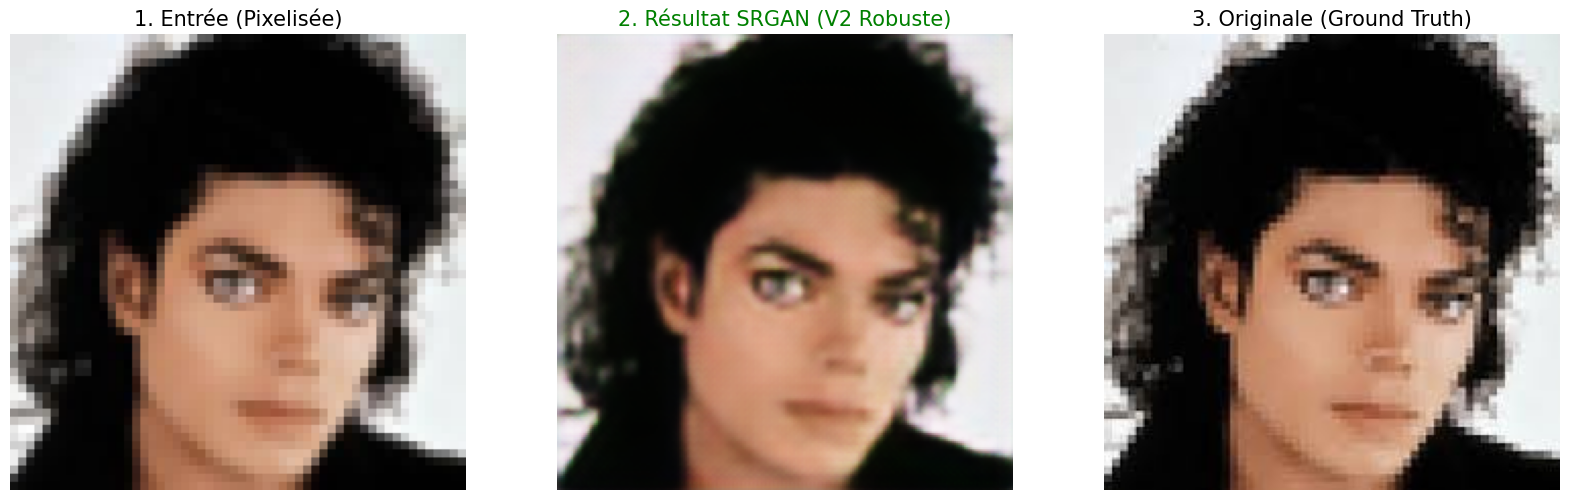

✅ Résultat sauvegardé : resultat_v2_1*9dbWWY4LzLIkjEHvDf4bDQ.jpg


In [5]:
# [11] TEST ET VISUALISATION
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

def test_custom_image():
    # S'assurer que le modèle est en mode évaluation
    generator.eval()

    print("📤 Veuillez uploader une image de test (JPG ou PNG)...")
    uploaded = files.upload()

    for fn in uploaded.keys():
        print(f'Traitement de {fn}...')

        # 1. Chargement
        img_path = fn
        original = Image.open(img_path).convert("RGB")

        # On redimensionne pour avoir des dimensions multiples de 4
        w, h = original.size
        w, h = (w // 4) * 4, (h // 4) * 4
        original = original.resize((w, h), Image.BICUBIC)

        # 2. Création de la LR (Basse Résolution)
        lr_image = original.resize((w // 4, h // 4), Image.BICUBIC)

        # 3. Inférence
        with torch.no_grad():
            # Transformation : ToTensor + Normalisation [-1, 1]
            transform_input = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

            img_tensor = transform_input(lr_image).unsqueeze(0).to(DEVICE)

            # Génération
            sr_tensor = generator(img_tensor)

            # 4. Post-traitement (Dé-normalisation)
            # Important : On repasse de [-1, 1] à [0, 1]
            sr_tensor = denormalize(sr_tensor)
            sr_tensor = torch.clamp(sr_tensor, 0, 1) # Sécurité

            sr_image = transforms.ToPILImage()(sr_tensor.squeeze(0).cpu())

        # 5. Affichage Comparatif
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))

        # LR (Zoomée pixelisée)
        lr_display = lr_image.resize((w, h), Image.NEAREST)
        axes[0].imshow(lr_display)
        axes[0].set_title("1. Entrée (Pixelisée)", fontsize=15)
        axes[0].axis('off')

        # SRGAN
        axes[1].imshow(sr_image)
        axes[1].set_title("2. Résultat SRGAN (V2 Robuste)", fontsize=15, color='green')
        axes[1].axis('off')

        # Originale
        axes[2].imshow(original)
        axes[2].set_title("3. Originale (Ground Truth)", fontsize=15)
        axes[2].axis('off')

        plt.show()

        # Sauvegarde
        save_name = f"resultat_v2_{fn}"
        sr_image.save(save_name)
        print(f"✅ Résultat sauvegardé : {save_name}")

# Lancer le test
test_custom_image()